# NFL Punt Research Proposal

## Background

The NFL has long been working to reduce the number of injuries sustained by its players, but the effort to reduce concussions has intensified in recent years due to the increasing occurrence of CTE and TBI caused by high-impact head trauma. A baseline for hypothesis-testing is provided in the first part of this document, based on the punt play and punt injury data for the 2016 and 2017 NFL seasons. In the second part of this proposal, the hypothesis and experiment design are laid out to test a possible solution for reducing concussions in punt plays, and possibly all NFL plays.

### Assumptions
This dataset is derived from the set of all punt plays in the 2016 and 2017 football seasons. Any conclusions drawn from analysis of this data assumes that punt plays and injury distribution during these two seasons are representative of all seasons (or at least seasons within the modern football era). The analysis in this report will be skewed if the number or logistics of injuries in other seasons varies significantly from the 2016 and 2017 seasons unless the 2016 and 2017 seasons denote a turning point in punt plays and punt injuries.

For ease of classifying weather into a manageable number of categories, I ignored temperatures and focused on weather that might impair game play quality such as precipitation, wind, and visibility. Some of the weather categories may have been over-generalized, but I do not believe this resulted in a gross mis-characterization in the role weather plays in causing punt injuries.

### Shortcomings
The data for injury plays contained only 38 records. This is small and could have contributed to bias in the statistical tests used to confirm or reject hypotheses. Specifically, the chi square test assumes at least 5 expected observations for each category, and I know that was not the case for some of the categories tested below.

In [1]:
#Import the necessary libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helper import *

from collections import Counter, OrderedDict
from math import floor
from scipy.stats import ttest_ind, chisquare
from IPython.display import Image
%matplotlib inline

In [2]:
#Import game data as a Pandas Data Frame
gamedata_df = pd.read_csv('game_data.csv')

#Check for NaN values
gamedata_df.isna().sum()

GameKey             0
Season_Year         0
Season_Type         0
Week                0
Game_Date           0
Game_Day            0
Game_Site           0
Start_Time          0
Home_Team           0
HomeTeamCode        0
Visit_Team          0
VisitTeamCode       0
Stadium             0
StadiumType        38
Turf                1
GameWeather        98
Temperature        66
OutdoorWeather    254
dtype: int64

In [3]:
#Check the types of the columns to determine how best to impute NaN values
gamedata_df.dtypes

GameKey             int64
Season_Year         int64
Season_Type        object
Week                int64
Game_Date          object
Game_Day           object
Game_Site          object
Start_Time         object
Home_Team          object
HomeTeamCode       object
Visit_Team         object
VisitTeamCode      object
Stadium            object
StadiumType        object
Turf               object
GameWeather        object
Temperature       float64
OutdoorWeather     object
dtype: object

## Dealing with Null Values and Standardizing Categorical Values

The three columns of interest in Game Data have null values. Since temperature is a float type, I would like to fill the null values with the series mean rounded to the floor integer. Before I do, I would like to know if any of the injury-producing plays is missing a temperature value, since that could contribute bias to the analysis. 

Turf and GameWeather are also missing values, however they are string objects and an Unknown value can be entered for any null values.This will not significantly impact the Turf analysis, but the GameWeather is missing around 15% of its values. 

In [4]:
#Create a Data Frame of just injury producing games for comparison with all games
injury_games_df = pd.merge(gamedata_df, pd.read_csv('video_review.csv'),
                           on=['GameKey', 'Season_Year'], how='inner')

#Replace temperature null values with the mean minus any decimal point precision
gamedata_df['Temperature'].fillna(floor(np.mean(gamedata_df['Temperature'])), inplace=True)

#Replace all null values in string columns with 'Unknown'
gamedata_df.fillna('Unknown', inplace=True)

#Standardize and reduce the number of weather values
gamedata_df = standardize_weather(gamedata_df)
#Standardize and reduce number of turf values
gamedata_df = standardize_turf(gamedata_df)

## Visualizing the Data: 
### Do environmental variables (weather, temperature, turf) play a significant factor in punt injuries?

Now that the data has been standardized, we can visualize the data and some statistics for the one column that contains numerical data. I need to merge the video_review file again with the updated game data frame to make comparisons. 

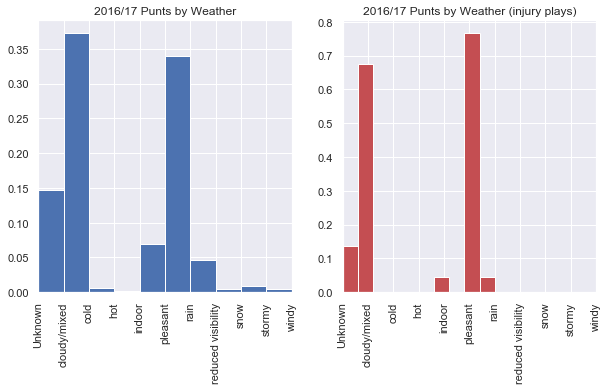

In [5]:
#Add numerical category columns for GameWeather and Turf
gamedata_df, weather_dict = num_category(gamedata_df, 'GameWeather', 'weather')
gamedata_df, turf_dict = num_category(gamedata_df, 'Turf', 'turf')

#Merge the video review of injuries with updated game data df and fill NaNs in video_review
injury_games_df = pd.merge(gamedata_df, pd.read_csv('video_review.csv'),
                           on=['GameKey', 'Season_Year'], how='inner')
injury_games_df.fillna('Unknown', inplace=True)

#Set the style with the Seaborn default and call a function to generate histograms comparing the distributions
#of all game weather and the weather during games producing injuries
sns.set()
compare_hists(gamedata_df['weather'], injury_games_df['weather'], label1=weather_dict.values(),
              label2=weather_dict.values(), title1='Weather', title2='Weather (injury plays)',
             figsize=(10, 5))

In [6]:
#Create a dictionary with frequency counts for weather during injury-producing games
injured_weather = dict(Counter(list(injury_games_df['weather'])))

#Create a dictionary with percent distributions of weather over all games and multiply by number injury games
game_weather = get_percentages(gamedata_df['weather'])
game_weather.update((k, v*38) for k, v in game_weather.items())

#Give 0 values for all weather types not found in injury-producing games
for key in game_weather.keys():
    if key not in injured_weather.keys():
        injured_weather[key] = 0
injured_weather = OrderedDict(sorted(injured_weather.items()))

#Use Chi Square Test to accept or reject null hypothesis
print('Weather Chi-Square Test: {}'.format(chisquare(list(injured_weather.values()), list(game_weather.values()))))

Weather Chi-Square Test: Power_divergenceResult(statistic=4.868793035994966, pvalue=0.8997685525718967)


This Chi-Square Test confirms the null hypothesis, that weather does not have significant correlation with injury, because of the large p-value.
### Conclusion: Weather has no demonstrably significant correlation to injury.

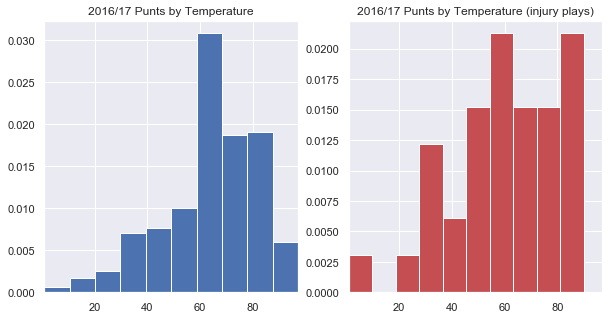

Temperature Mean(total): 64.11861861861861  Standard Deviation: 17.605351234376982

Temperature Mean(injury): 60.729729729729726  Standard Deviation: 21.001478260259283

Temperature T-Test: Ttest_indResult(statistic=-0.9502789757067102, pvalue=0.347854407196727)


In [7]:
#Call a function to generate histograms comparing the distributions of all game temperature and the temperature 
#during games producing injuries. Check the mean and standard deviation of both sets of data
compare_hists(gamedata_df['Temperature'], injury_games_df['Temperature'],
              title1='Temperature', title2='Temperature (injury plays)',
             figsize=(10, 5))

print('Temperature Mean(total): {}  Standard Deviation: {}\n'.format(np.mean(gamedata_df['Temperature']), np.std(gamedata_df['Temperature'])))
print('Temperature Mean(injury): {}  Standard Deviation: {}\n'.format(np.mean(injury_games_df['Temperature']), np.std(injury_games_df['Temperature'])))
#Perform T-Tests to determine the likelihood that the samples are representative of the same population
print('Temperature T-Test: {}'.format(ttest_ind(injury_games_df['Temperature'], gamedata_df['Temperature'], equal_var=False)))

This T-Test may or may not confirm the null hypothesis. It is worth looking into a Power Test to see whether there is a significant enough sample to reject the alternate hypothesis.

### Conclusion: Temperature may or may not have correlation to injury.

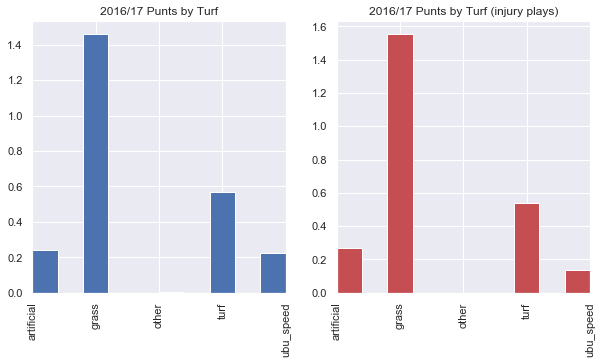

In [8]:
#Call a function to generate histograms comparing the distributions of all turf types and those during games producing injuries
compare_hists(gamedata_df['turf'], injury_games_df['turf'], label1=turf_dict.values(), 
              label2=turf_dict.values(), title1='Turf', title2='Turf (injury plays)')

In [9]:
#Create a dictionary with frequency counts for turf during injury-producing games
injured_turf = dict(Counter(list(injury_games_df['turf'])))

#Create a dictionary with percent distributions of turf type over all games and multiply by number injury games
game_turf = get_percentages(gamedata_df['turf'])
game_turf.update((k, v*38) for k, v in game_turf.items())

#Give 0 values for all turf types not found in injury-producing games
for key in game_turf.keys():
    if key not in injured_turf.keys():
        injured_turf[key] = 0
injured_turf = OrderedDict(sorted(injured_turf.items()))

#Use Chi Square Test to accept or reject null hypothesis
print('Turf Chi-Square Test: {}'.format(chisquare(list(injured_turf.values()), list(game_turf.values()))))

Turf Chi-Square Test: Power_divergenceResult(statistic=0.7449506300878249, pvalue=0.9456720821759017)


This Chi-Square Test confirms the null hypothesis, that turf type does not have significant correlation with injury, because of the large p-value.
### Conclusion: Turf has no demonstrably significant correlation to injury.

## Do injuries occur more often to players who fill certain roles?

To answer this question, I want to see if the distribution of roles filled by players who get injured is significantly different from the total distribution of roles in punt plays all punt plays.

In [10]:
#Import player role data by punt play into a Pandas Data Frame
player_role_df = pd.read_csv('play_player_role_data.csv')

#Create a column for groups of roles that are similar to reduce number of unique values
player_role_df = standardize_role_groups(player_role_df)

#Create a Data Frame of just the players getting injured
injured_role_df = pd.merge(player_role_df, pd.read_csv('video_review.csv'), how='inner', on=['Season_Year', 'GameKey', 'PlayID', 'GSISID'])

#Create a dictionary for percentage of total for each role group
group_dict = get_percentages(player_role_df['Group'])

#Create a dictionary for the percentage of injured role group
injured_group_dict = get_percentages(injured_role_df['Group'])


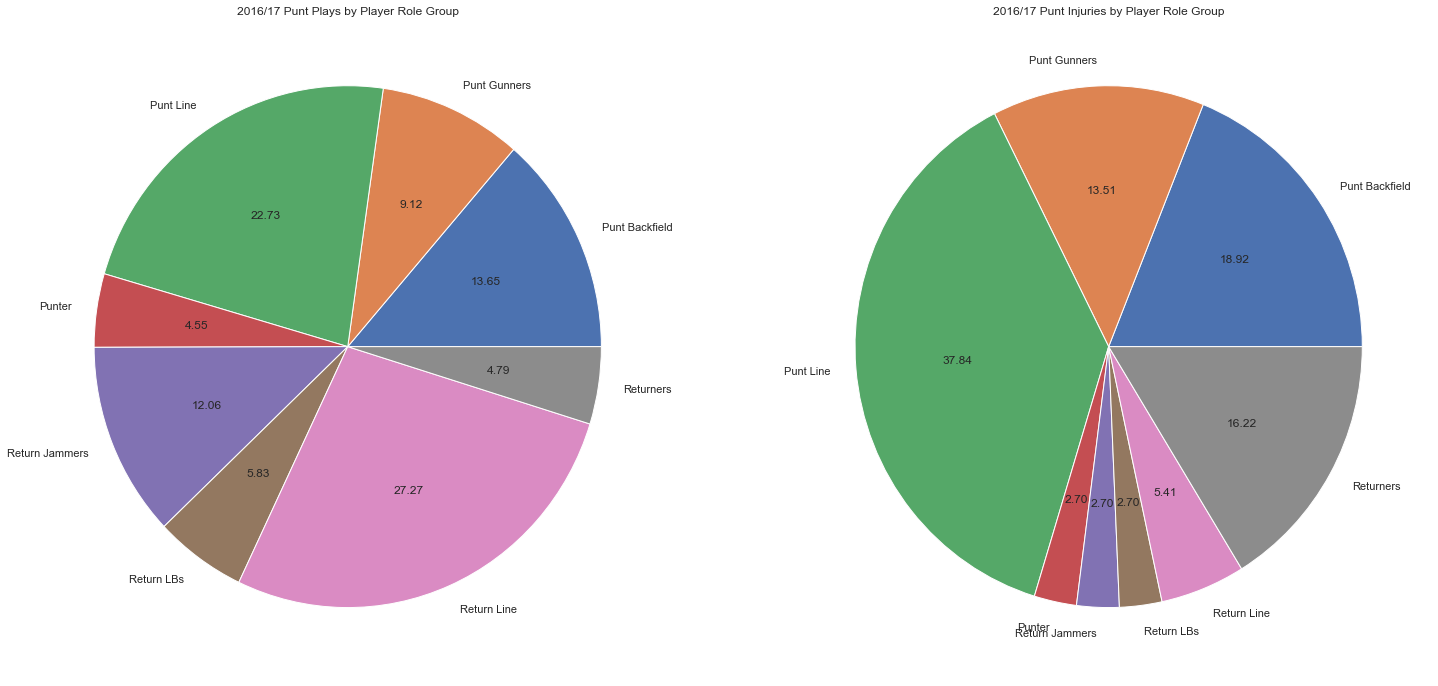

In [11]:
#Create pie charts comparing the distribution of all groups and the distribution of injured groups
plt.figure(figsize=(25,12))

plt.subplot(1, 2, 1)
plt.pie(group_dict.values(), labels=group_dict.keys(), autopct='%0.2f')
plt.title('2016/17 Punt Plays by Player Role Group')

plt.subplot(1, 2, 2)
plt.pie(injured_group_dict.values(), labels=injured_group_dict.keys(), autopct='%0.2f') 
plt.title('2016/17 Punt Injuries by Player Role Group')
plt.show()

In [12]:
#Update the percent distributions with their frequency count over 38 injury-producing games
group_dict.update((k, v*38) for k, v in group_dict.items())
injured_group_dict.update((k, v*38) for k, v in injured_group_dict.items())

#Use Chi Square Test to accept or reject null hypothesis
print('Role Group Chi-Square Test: {}'.format(chisquare(list(injured_group_dict.values()), list(group_dict.values()))))

Role Group Chi-Square Test: Power_divergenceResult(statistic=26.09428768608364, pvalue=0.0004844980425985544)


This Chi Square test supports the alternate hypothesis, that there is a significant correlation between role group and injury.
### Conclusion: The following role groups are more susceptible to injury.

### - Punt Line and Punt Backfield

### - Returners

### - Gunners


## Do Impact Type and Activity Play a Role in Injuries?

In the last section, we saw which role groups experience disproportionately high rates of injury. Let's see what the distribution of activity type and impact type looks like by role group. This will give context to video review, so we know what we are looking for in injury plays.

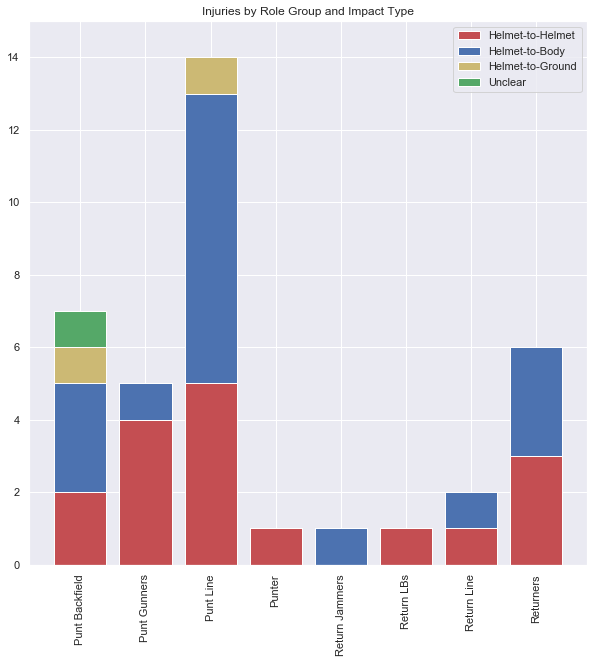

In [13]:
x_len = range(len(injured_role_df['Group'].unique()))

#Create arrays with the frequency counts for each impact type by role group
hh = np.array([2, 4, 5, 1, 0, 1, 1, 3])
hb = np.array([3, 1, 8, 0, 1, 0, 1, 3])
hg = np.array([1, 0, 1, 0, 0, 0, 0, 0])
un = np.array([1, 0, 0, 0, 0, 0, 0, 0])

#Create stacked bar charts showing the impact types and activity by player role group
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(x_len, height=hh, color='r')
ax.bar(x_len, height=hb, color='b', bottom=hh)
ax.bar(x_len, height=hg, color='y', bottom=hh+hb)
ax.bar(x_len, height=un, color='g', bottom=hh+hb+hg)

ax.set_title('Injuries by Role Group and Impact Type')
ax.set_ylim((0, 15))
ax.set_xticklabels(('', 'Punt Backfield', 'Punt Gunners', 'Punt Line', 'Punter', 'Return Jammers',
                    'Return LBs', 'Return Line', 'Returners'), rotation='vertical')
ax.legend(labels=('Helmet-to-Helmet', 'Helmet-to-Body', 'Helmet-to-Ground', 'Unclear'))

plt.show()

### Conclusion: Helmet-to-Helmet and Helmet-to-Body equally likely to injure any role group

Regardless of position, every injury was about equally likely to be caused by a helmet-to-helmet impact or a helmet-to-body impact. Helmet-to-ground was less likely to cause injury and only one impact type was unclear.

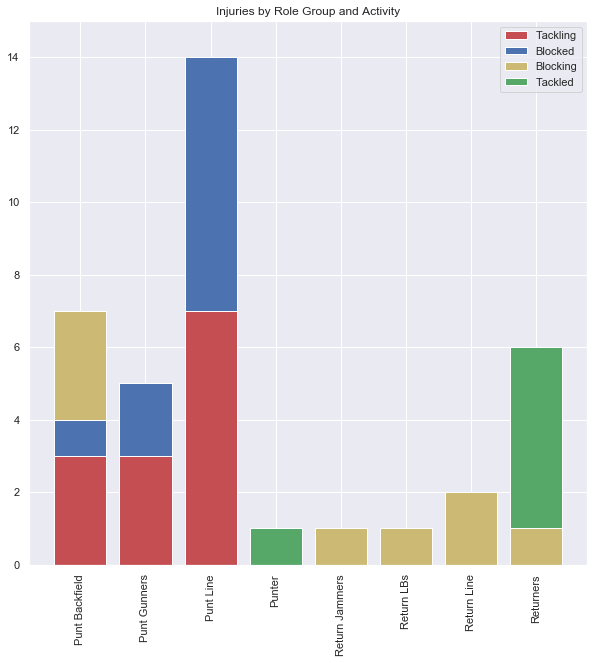

In [14]:
#Create arrays with the frequency counts for each activity by role group
tg = np.array([3, 3, 7, 0, 0, 0, 0, 0])
bd = np.array([1, 2, 7, 0, 0, 0, 0, 0])
bg = np.array([3, 0, 0, 0, 1, 1, 2, 1])
td = np.array([0, 0, 0, 1, 0, 0, 0, 5])

#Create stacked bar charts showing the impact types and activity by player role group
fig, ax = plt.subplots(figsize=(10, 10))

ax.bar(x_len, height=tg, color='r')
ax.bar(x_len, height=bd, color='b', bottom=tg)
ax.bar(x_len, height=bg, color='y', bottom=tg+bd)
ax.bar(x_len, height=td, color='g', bottom=tg+bd+bg)

ax.set_title('Injuries by Role Group and Activity')
ax.set_ylim((0, 15))
ax.set_xticklabels(('', 'Punt Backfield', 'Punt Gunners', 'Punt Line', 'Punter', 'Return Jammers',
                    'Return LBs', 'Return Line', 'Returners'), rotation='vertical')
ax.legend(labels=('Tackling', 'Blocked', 'Blocking', 'Tackled'))

plt.show()

### Activity types while injured are delineated fairly evenly among role groups.

## Video Review

The following actions stood out as those most likely to cause injury from a review of the video footage.

### - Diving Tackles

### - High-speed Helmet-to-Helmet

### - Gang Tackling


# Research Proposal

How can we address some of the injury producing patterns in these play. You could ban diving, but I think that would be impractical and would outrage fans and players alike. There does not seem to be any aspect of game play that can be modified to reduce the types of injuries shown here without hampering gameplay.

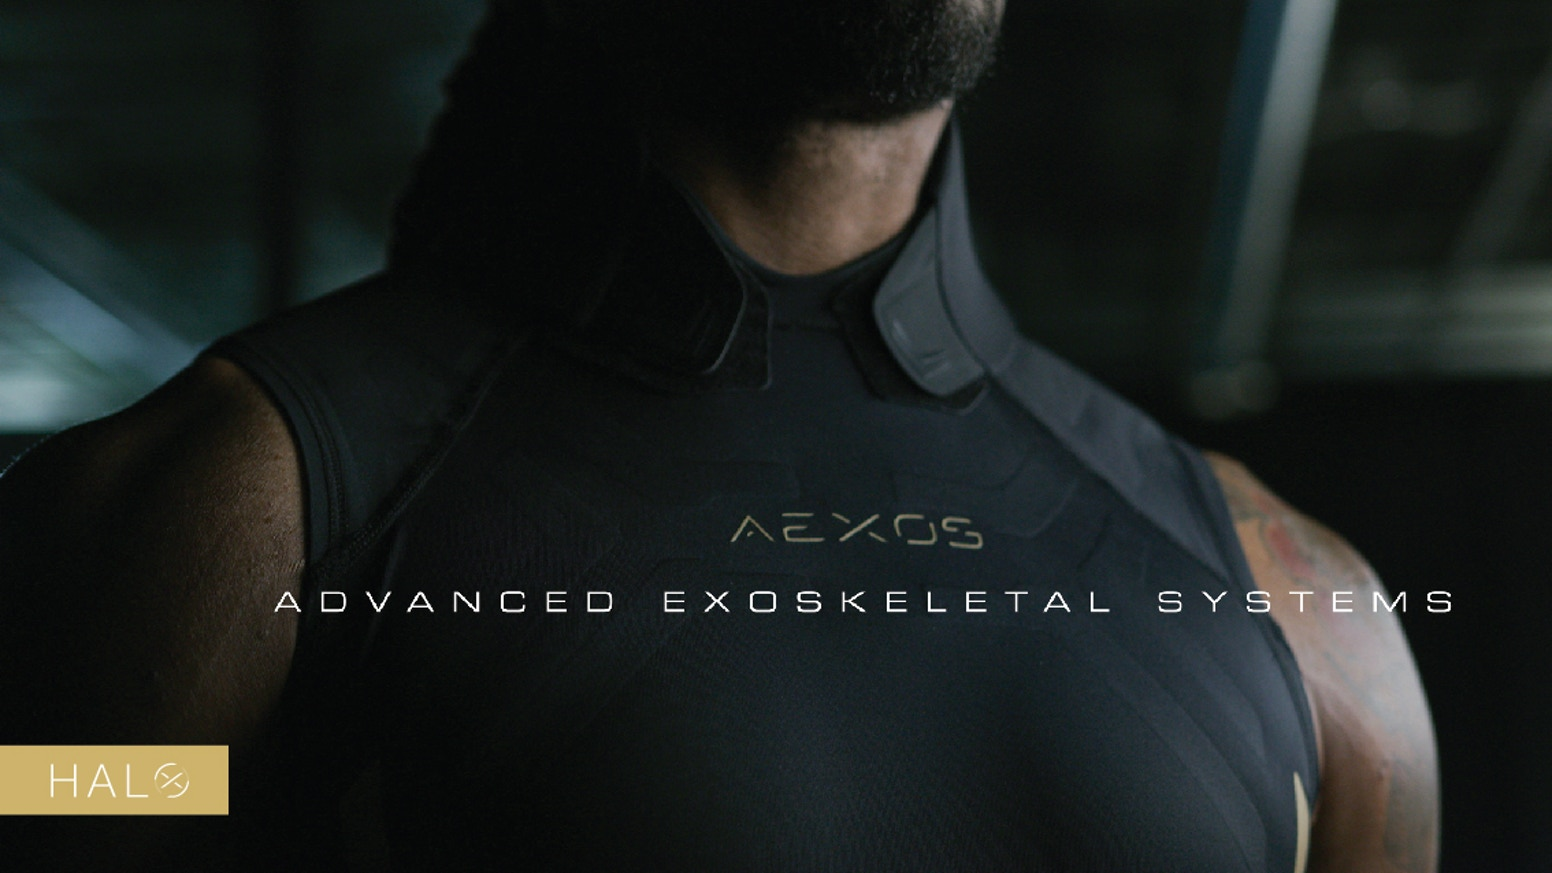

In [15]:
Image(filename='halo.jpg')

## Hypothesis

#### Mandating all players wear AEXOS or similar equipment will result in  > 25% reduction in injury-to-near-miss (I2N) ratio

A startup has been working on a compression-shirt style piece of equipment designed to reduce the number of injuries involving whiplash and other high-speed, extreme deceleration events involving the head and neck in high-impact sports. I propose that this extra support for the neck will significantly reduce the percentage of potentially injury-causing collisions that actually result in injuries.

## A/A Testing

Above I looked for correlation between features and injuries, but now that I have outlined features of interest in injury plays (diving tackles, high-speed helmet-to-helmet collisions, and gang-tackles), I need to go back through the video for the rest of the punt plays to highlight any near-misses where those events occurred but did not result in injury. This will give me a baseline ratio to see what percentage of those activities are resulting in injury. I would also like to get information on the previous 5 seasons to ensure that the ratio for the past two seasons was not anamolous. This would require some support, not only to get the additional data, but also to perform video reviews to deteremine near-misses. However, I think a ratio of near-misses to injuries provides a better metric than just injury count.

## Success Metrics

Over the next two seasons, injuries-to-near-misses (I2N) will be measured for the test sample and the control sample and compare to that of the last 5 seasons.

#### Success metrics: I2N ratios from test season vs. last 5 seasons (L5)

|  Test Sample  | Control Sample |  Outcome  |  
|---------------|----------------|-----------|
|   > 75% L5    |   > 50% L5     | + 1 year  |
|   > 75% L5    |   < 50% L5     | terminate |
|  50%-75% L5   |   > 50% L5     | implement |
|  50%-75% L5   |   < 50% L5     | + 1 year  |
|   < 25% L5    |   > 50% L5     | implement |
|   < 25% L5    |   < 50% L5     |investigate|
        

## Before Implementation

### Random Sampling
Two teams will be randomly selected from each division of 4 teams. All players from the two randomly selected teams will wear the new equipment for all games during the two test seasons. Players from the other two teams in each division will not be allowed to wear the equipment. Geographic distribution and schedule strength distribution should be accounted for with the sample being drawn evenly and at random from each of the division in both the AFC and the NFC. 

### Feasibility and Compliance
During spring training camps, a randomly selected group of 225 players (10 players from each of the offensive and defensive positions and 5 kickers/punters) from the test sample will be asked to wear the equipment for 2 weeks of practice and will be surveyed about the perceived comfort and level of added protection. They will also be asked whether or not it is perceived as a burden during gameplay. This should allow time to perform any final modifcations to the equipment in time for the upcoming preseason. 

Compliance will be monitored through locker room checks by league officials both before and after the games. Fines will be administered to players who fail to comply with the new equipment rules for the pilot seasons. All injuries in the test sample will be followed up with a check to see whether the player was wearing the equipment and wearing it properly. 

### Possible Complications
Before starting the season, I need to look into rule changes, changes in the demographic makeup of the player base and changes to gameplay style of teams. This will help identify sources of error to control for when analyzing the data at the end of the pilot seasons.

## Rollout

At the beginning of the next season, the new equipment will be rolled out to all players on teams in the test group and compliance checks and fines will begin from the first game of the preseason. The first analysis of the I2N ratio will be taken at the end of the preseason and then every week after that. If values for I2N fall below 25% L5 or rise above 150% L5 for the season-to-date beyond regular season week 6, analysis will be conducted to determine whether factors outside the test equipment are complicating the results of the test. 

### Analysis
Before the season, data will be gathered on player demographics, strength and endurance training regimens, and team gameplay schemes to be measured against previous seasons for significant changes. Each week following the last week of the preseason, the season-to-date I2N will be calculated for both the test sample and the control sample and measured against the season-to-date I2N in the last five seasons. The comnparison can be made visually with a histogram and statistically with a T-Test. The mean I2N can also be directly compared, with the end goal being < 25% L5 for the test sample as denoted in the success metrics table above. 